# Validation Report: Standalone Detection

Objective:
- Validate `separation.detection` against pre-saved baseline artifacts from the original pipeline.

Data sources:
- `/mnt/nas02/Dataset/suite2p/detection/test_input.pkl` (captured standalone execution input)
- `/mnt/nas02/Dataset/suite2p/detection/test_output.pkl` (ground-truth output from original pipeline capture)

Critical architecture rule:
- This notebook must not import the original parent library (`suite2p`).
- Validation is performed by replaying standalone code against captured artifacts only.


In [1]:
from __future__ import annotations

import builtins
import importlib
import importlib.util
import json
import pickle
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

if any(name == "suite2p" or name.startswith("suite2p.") for name in sys.modules):
    raise RuntimeError(
        "Architecture rule violation: `suite2p` is already loaded in this kernel. "
        "Restart the kernel and run this notebook from the top."
    )


class BlockSuite2PImports:
    # Block suite2p imports to prevent namespace pollution.
    def __enter__(self):
        self._orig_import = builtins.__import__

        def guarded_import(name, globals=None, locals=None, fromlist=(), level=0):
            if name == "suite2p" or name.startswith("suite2p."):
                raise ImportError(f"Blocked import by architecture rule: {name}")
            return self._orig_import(name, globals, locals, fromlist, level)

        builtins.__import__ = guarded_import
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        builtins.__import__ = self._orig_import


def find_repo_root(start: Path):
    current = start.resolve()
    for candidate in [current, *current.parents]:
        if (candidate / ".git").exists():
            return candidate
    return None


def load_module_from_file(module_name: str, file_path: Path):
    spec = importlib.util.spec_from_file_location(module_name, str(file_path))
    if spec is None or spec.loader is None:
        raise ImportError(f"Failed to create spec for {module_name} from {file_path}")
    module = importlib.util.module_from_spec(spec)
    sys.modules[module_name] = module
    spec.loader.exec_module(module)
    return module


def import_standalone_helpers(notebook_dir: Path, repo_root):
    try:
        from separation.detection.binary import BinaryFile as _BinaryFile
        from separation.detection.serialization import deserialize_object as _deserialize_object
        return _BinaryFile, _deserialize_object, "standard"
    except Exception:
        pass

    if repo_root is not None:
        repo_root_str = str(repo_root)
        if repo_root_str not in sys.path:
            sys.path.insert(0, repo_root_str)
        try:
            from separation.detection.binary import BinaryFile as _BinaryFile
            from separation.detection.serialization import deserialize_object as _deserialize_object
            return _BinaryFile, _deserialize_object, "repo_root_bootstrap"
        except Exception:
            pass

    package_dir = notebook_dir
    if not (package_dir / "binary.py").exists():
        package_dir = notebook_dir / "separation" / "detection"
    if not (package_dir / "binary.py").exists():
        raise ImportError(
            f"Could not locate standalone detection helper modules near {notebook_dir}."
        )

    binary_mod = load_module_from_file(
        "standalone_detection_binary_local", package_dir / "binary.py"
    )
    serialization_mod = load_module_from_file(
        "standalone_detection_serialization_local", package_dir / "serialization.py"
    )
    return binary_mod.BinaryFile, serialization_mod.deserialize_object, "local_loader"


def import_standalone_package(package_dir: Path, repo_root):
    try:
        module = importlib.import_module("separation.detection")
        return module, "separation.detection", "standard"
    except Exception:
        pass

    if repo_root is not None:
        repo_root_str = str(repo_root)
        if repo_root_str not in sys.path:
            sys.path.insert(0, repo_root_str)
        try:
            module = importlib.import_module("separation.detection")
            return module, "separation.detection", "repo_root_bootstrap"
        except Exception:
            pass

    init_file = package_dir / "__init__.py"
    if not init_file.exists():
        raise FileNotFoundError(f"Standalone package init not found: {init_file}")

    module_name = "standalone_detection_local"
    spec = importlib.util.spec_from_file_location(
        module_name,
        str(init_file),
        submodule_search_locations=[str(package_dir)],
    )
    if spec is None or spec.loader is None:
        raise ImportError(f"Failed to create package spec from {init_file}")
    module = importlib.util.module_from_spec(spec)
    sys.modules[module_name] = module
    spec.loader.exec_module(module)
    return module, module_name, "local_loader"


notebook_dir = Path.cwd().resolve()
repo_root = find_repo_root(notebook_dir)

BinaryFile, deserialize_object, import_strategy_used = import_standalone_helpers(
    notebook_dir=notebook_dir,
    repo_root=repo_root,
)

architecture_guard_initialized = True
print("Architecture guard initialized.")
print(f"Python {sys.version.split()[0]}")
print(f"notebook_dir={notebook_dir}")
print(f"repo_root={repo_root}")
print(f"helper_import_strategy={import_strategy_used}")


Architecture guard initialized.
Python 3.9.25
notebook_dir=/home/yz/suite2p/separation/detection
repo_root=/home/yz/suite2p
helper_import_strategy=repo_root_bootstrap


In [2]:
artifact_dir = Path("/mnt/nas02/Dataset/suite2p/detection")

if not artifact_dir.exists():
    raise FileNotFoundError(f"Artifact directory does not exist: {artifact_dir}")

package_dir = repo_root / "separation" / "detection" if repo_root is not None else Path("separation/detection")

test_input_path = artifact_dir / "test_input.pkl"
test_output_path = artifact_dir / "test_output.pkl"
manifest_path = artifact_dir / "capture_manifest.json"

missing = [
    str(p) for p in [test_input_path, test_output_path, manifest_path]
    if not p.exists()
]
if missing:
    raise FileNotFoundError(
        "Missing required detection artifacts: " + ", ".join(missing)
    )

print(f"artifact_dir:     {artifact_dir}")
print(f"package_dir:      {package_dir}")
print(f"test_input_path:  {test_input_path}")
print(f"test_output_path: {test_output_path}")
print(f"manifest_path:    {manifest_path}")


artifact_dir:     /mnt/nas02/Dataset/suite2p/detection
package_dir:      /home/yz/suite2p/separation/detection
test_input_path:  /mnt/nas02/Dataset/suite2p/detection/test_input.pkl
test_output_path: /mnt/nas02/Dataset/suite2p/detection/test_output.pkl
manifest_path:    /mnt/nas02/Dataset/suite2p/detection/capture_manifest.json


In [3]:
with test_input_path.open("rb") as f:
    captured_input_serialized = pickle.load(f)

print("Loaded captured_input_serialized")
print("top-level keys:", sorted(captured_input_serialized.keys()))
print("type summary:")
for key in sorted(captured_input_serialized.keys()):
    value = captured_input_serialized[key]
    if isinstance(value, dict) and "__type__" in value:
        print(f"  - {key}: serialized {value['__type__']}")
    else:
        print(f"  - {key}: {type(value).__name__}")


Loaded captured_input_serialized
top-level keys: ['badframes', 'classifier_path', 'device', 'diameter', 'f_reg', 'fs', 'meanImg_chan2', 'mov', 'preclassify', 'settings', 'tau', 'xrange', 'yrange']
type summary:
  - badframes: serialized ndarray
  - classifier_path: serialized path
  - device: serialized torch_device
  - diameter: serialized ndarray
  - f_reg: serialized binary_file
  - fs: float
  - meanImg_chan2: NoneType
  - mov: NoneType
  - preclassify: float
  - settings: dict
  - tau: float
  - xrange: list
  - yrange: list


In [4]:
with test_output_path.open("rb") as f:
    expected_output_serialized = pickle.load(f)

print("Loaded expected_output_serialized")
print("expected_output type:", type(expected_output_serialized).__name__)
if isinstance(expected_output_serialized, dict):
    print("top-level keys:", sorted(expected_output_serialized.keys()))
elif isinstance(expected_output_serialized, tuple):
    print("tuple length:", len(expected_output_serialized))
    for i, value in enumerate(expected_output_serialized):
        print(f"  - idx {i}: {type(value).__name__}")


Loaded expected_output_serialized
expected_output type: dict
top-level keys: ['__type__', 'items']


In [5]:
opened_binary_handles = []

def build_binary_file(desc):
    required = ("filename", "Ly", "Lx", "n_frames", "dtype", "write")
    missing = [key for key in required if key not in desc]
    if missing:
        raise ValueError(f"Binary descriptor missing keys {missing}: {desc}")

    filename = Path(desc["filename"])
    if not filename.exists():
        raise FileNotFoundError(f"Binary file not found: {filename}")

    bf = BinaryFile(
        Ly=int(desc["Ly"]),
        Lx=int(desc["Lx"]),
        filename=str(filename),
        n_frames=int(desc["n_frames"]),
        dtype=str(desc["dtype"]),
        write=bool(desc["write"]),
    )
    opened_binary_handles.append(bf)
    return bf

kwargs = deserialize_object(
    captured_input_serialized,
    binary_file_factory=build_binary_file,
)
expected_output = deserialize_object(expected_output_serialized)

print("Deserialized kwargs keys:", sorted(kwargs.keys()))
print("Deserialized expected_output type:", type(expected_output).__name__)
if isinstance(expected_output, tuple):
    print("Deserialized expected_output tuple length:", len(expected_output))


Deserialized kwargs keys: ['badframes', 'classifier_path', 'device', 'diameter', 'f_reg', 'fs', 'meanImg_chan2', 'mov', 'preclassify', 'settings', 'tau', 'xrange', 'yrange']
Deserialized expected_output type: tuple
Deserialized expected_output tuple length: 3


In [6]:
if "f_reg" not in kwargs:
    raise KeyError("Expected `f_reg` in kwargs for frame snapshot.")

FRAME_INDEX = min(kwargs["f_reg"].n_frames // 2, kwargs["f_reg"].n_frames - 1)
original_frame_snapshot = kwargs["f_reg"][FRAME_INDEX].copy()

print(f"FRAME_INDEX={FRAME_INDEX}")
print(
    "original_frame_snapshot:",
    original_frame_snapshot.shape,
    original_frame_snapshot.dtype,
)


FRAME_INDEX=100
original_frame_snapshot: (662, 788) int16


In [7]:
new_output = None
standalone_frame_snapshot = None
architecture_guard_status = False
standalone_package_name = None
package_import_strategy = None

try:
    with BlockSuite2PImports():
        standalone_module, standalone_package_name, package_import_strategy = import_standalone_package(
            package_dir=package_dir,
            repo_root=repo_root,
        )
        architecture_guard_status = True
        new_output = standalone_module.detection_wrapper(**kwargs)

    standalone_frame_snapshot = kwargs["f_reg"][FRAME_INDEX].copy()

    print("Standalone execution completed.")
    print(f"standalone_package_name={standalone_package_name}")
    print(f"package_import_strategy={package_import_strategy}")
    if isinstance(new_output, tuple):
        print("new_output tuple length:", len(new_output))
finally:
    for bf in opened_binary_handles:
        try:
            bf.close()
        except Exception as exc:
            print(f"Warning: failed to close binary handle {getattr(bf, 'filename', '<unknown>')}: {exc}")


Standalone execution completed.
standalone_package_name=separation.detection
package_import_strategy=standard
new_output tuple length: 3


In [8]:
comparison_rows = []

def add_row(path, kind, expected, actual, passed, detail, max_abs_error=None):
    shape_expected = tuple(expected.shape) if isinstance(expected, np.ndarray) else None
    shape_actual = tuple(actual.shape) if isinstance(actual, np.ndarray) else None
    comparison_rows.append(
        {
            "path": path,
            "kind": kind,
            "shape_expected": shape_expected,
            "shape_actual": shape_actual,
            "pass": bool(passed),
            "max_abs_error": max_abs_error,
            "detail": detail,
        }
    )

def compare_objects(expected, actual, path="root"):
    if isinstance(expected, dict):
        if not isinstance(actual, dict):
            add_row(path, "dict", expected, actual, False, f"type mismatch: expected dict, got {type(actual).__name__}")
            return

        expected_keys = set(expected.keys())
        actual_keys = set(actual.keys())
        if expected_keys != actual_keys:
            missing = sorted(expected_keys - actual_keys)
            extra = sorted(actual_keys - expected_keys)
            add_row(
                path,
                "dict_keys",
                expected,
                actual,
                False,
                f"key mismatch; missing={missing}, extra={extra}",
            )

        for key in sorted(expected_keys & actual_keys):
            compare_objects(expected[key], actual[key], path=f"{path}.{key}")
        return

    if isinstance(expected, tuple):
        if not isinstance(actual, tuple):
            add_row(path, "tuple", expected, actual, False, f"type mismatch: expected tuple, got {type(actual).__name__}")
            return
        if len(expected) != len(actual):
            add_row(path, "tuple_len", expected, actual, False, f"length mismatch: {len(expected)} != {len(actual)}")
        for idx, (exp_item, act_item) in enumerate(zip(expected, actual)):
            compare_objects(exp_item, act_item, path=f"{path}[{idx}]")
        return

    if isinstance(expected, list):
        if not isinstance(actual, list):
            add_row(path, "list", expected, actual, False, f"type mismatch: expected list, got {type(actual).__name__}")
            return
        if len(expected) != len(actual):
            add_row(path, "list_len", expected, actual, False, f"length mismatch: {len(expected)} != {len(actual)}")
        for idx, (exp_item, act_item) in enumerate(zip(expected, actual)):
            compare_objects(exp_item, act_item, path=f"{path}[{idx}]")
        return

    if isinstance(expected, np.ndarray):
        if not isinstance(actual, np.ndarray):
            add_row(path, "ndarray", expected, actual, False, f"type mismatch: expected ndarray, got {type(actual).__name__}")
            return

        if expected.dtype != actual.dtype:
            add_row(path, "ndarray_dtype", expected, actual, False, f"dtype mismatch: {expected.dtype} != {actual.dtype}")
            return

        if expected.shape != actual.shape:
            add_row(path, "ndarray_shape", expected, actual, False, f"shape mismatch: {expected.shape} != {actual.shape}")
            return

        if expected.dtype == object:
            for idx in np.ndindex(expected.shape):
                compare_objects(expected[idx], actual[idx], path=f"{path}[{idx}]")
            return

        if np.issubdtype(expected.dtype, np.floating):
            diff = np.abs(expected.astype(np.float64) - actual.astype(np.float64))
            max_abs_error = float(np.nanmax(diff)) if diff.size else 0.0
            try:
                np.testing.assert_allclose(expected, actual, rtol=0.0, atol=0.0, equal_nan=True)
                add_row(path, "ndarray_float", expected, actual, True, "exact float match", max_abs_error=max_abs_error)
            except AssertionError as exc:
                add_row(path, "ndarray_float", expected, actual, False, str(exc).splitlines()[0], max_abs_error=max_abs_error)
        else:
            passed = bool(np.array_equal(expected, actual))
            add_row(
                path,
                "ndarray_exact",
                expected,
                actual,
                passed,
                "exact array match" if passed else "array values differ",
                max_abs_error=None,
            )
        return

    if type(expected) is not type(actual):
        add_row(path, "scalar_type", expected, actual, False, f"type mismatch: {type(expected).__name__} != {type(actual).__name__}")
        return

    passed = expected == actual
    add_row(path, "scalar", expected, actual, passed, "exact scalar match" if passed else f"value mismatch: {expected!r} != {actual!r}")

compare_objects(expected_output, new_output)

failed_rows = [row for row in comparison_rows if not row["pass"]]
overall_pass = len(failed_rows) == 0

print(f"Total checks: {len(comparison_rows)}")
print(f"Passed: {len(comparison_rows) - len(failed_rows)}")
print(f"Failed: {len(failed_rows)}")
print(f"Overall PASS: {overall_pass}")

print("\nPer-top-level report:")
top_level_report = {}
for idx in range(3):
    prefix = f"root[{idx}]"
    rows = [
        row for row in comparison_rows
        if row["path"] == prefix or row["path"].startswith(prefix + ".") or row["path"].startswith(prefix + "[")
    ]
    key_pass = bool(rows) and all(row["pass"] for row in rows)
    float_errors = [row["max_abs_error"] for row in rows if row["max_abs_error"] is not None]
    max_abs_error = max(float_errors) if float_errors else None
    top_level_report[prefix] = {
        "pass": key_pass,
        "max_abs_error": max_abs_error,
        "n_checks": len(rows),
    }
    print(f"  - {prefix:8s} PASS={key_pass} max_abs_error={max_abs_error} n_checks={len(rows)}")

if failed_rows:
    print("\nFailed rows:")
    for row in failed_rows:
        print(
            f"  - {row['path']} | kind={row['kind']} | "
            f"max_abs_error={row['max_abs_error']} | detail={row['detail']}"
        )


Total checks: 1323
Passed: 1323
Failed: 0
Overall PASS: True

Per-top-level report:
  - root[0]  PASS=True max_abs_error=0.0 n_checks=13
  - root[1]  PASS=True max_abs_error=0.0 n_checks=1309
  - root[2]  PASS=True max_abs_error=None n_checks=1


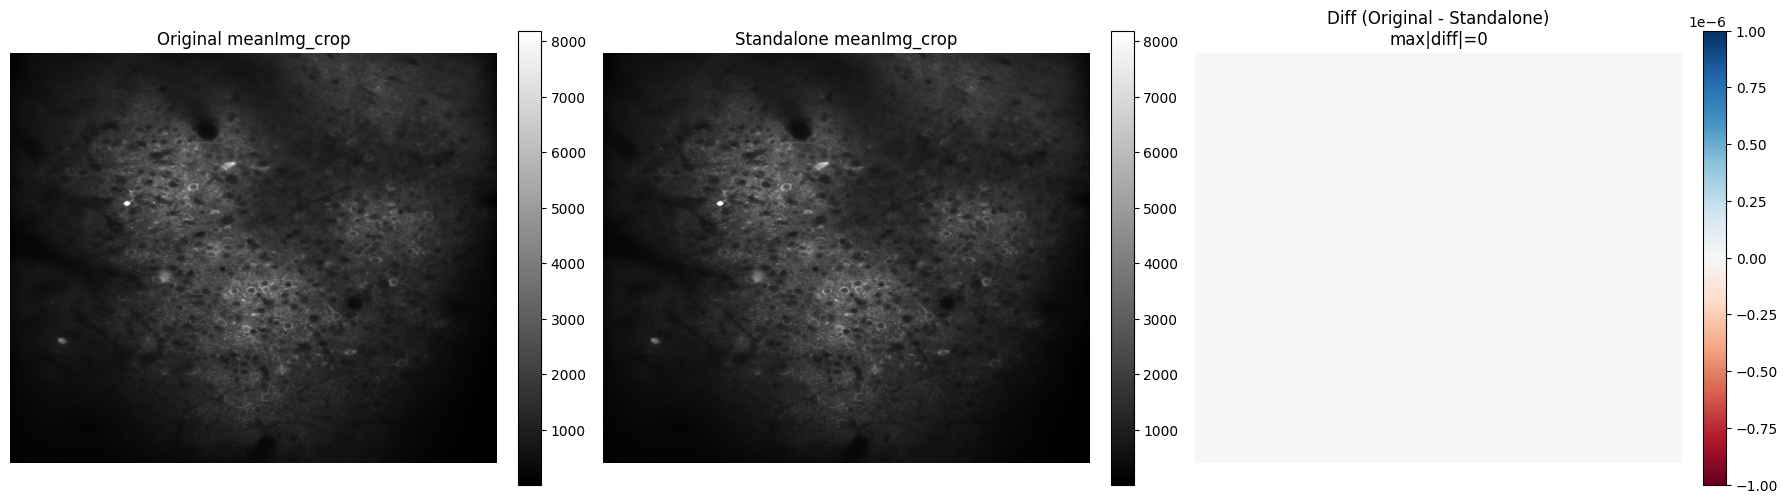

In [9]:
expected_new_settings, expected_stat, expected_redcell = expected_output
new_new_settings, new_stat, new_redcell = new_output

mean_expected = expected_new_settings["meanImg_crop"].astype(np.float32)
mean_new = new_new_settings["meanImg_crop"].astype(np.float32)
mean_diff = mean_expected - mean_new
mean_diff_max = float(np.max(np.abs(mean_diff))) if mean_diff.size else 0.0
mean_vlim = mean_diff_max if mean_diff_max > 0 else 1e-6

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
im0 = axes[0].imshow(mean_expected, cmap="gray")
axes[0].set_title("Original meanImg_crop")
axes[0].axis("off")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(mean_new, cmap="gray")
axes[1].set_title("Standalone meanImg_crop")
axes[1].axis("off")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

im2 = axes[2].imshow(mean_diff, cmap="RdBu", vmin=-mean_vlim, vmax=mean_vlim)
axes[2].set_title(f"Diff (Original - Standalone)\nmax|diff|={mean_diff_max:.6g}")
axes[2].axis("off")
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


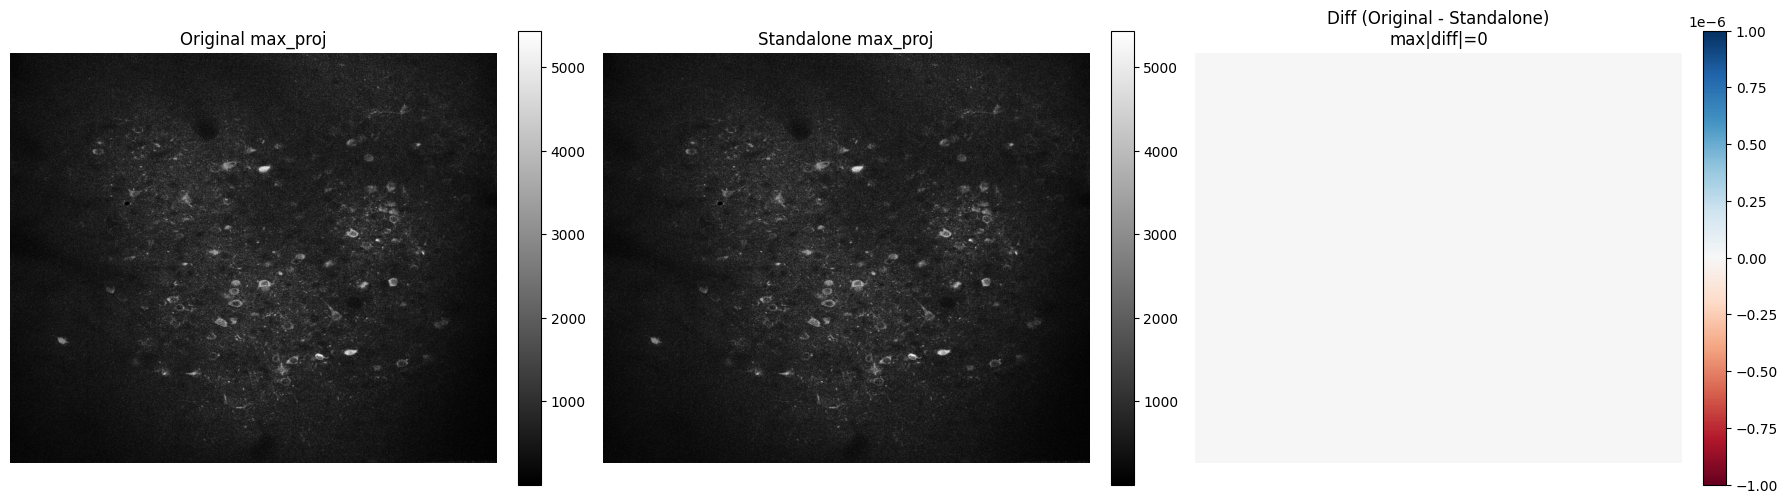

In [10]:
max_expected = expected_new_settings["max_proj"].astype(np.float32)
max_new = new_new_settings["max_proj"].astype(np.float32)
max_diff = max_expected - max_new
max_diff_max = float(np.max(np.abs(max_diff))) if max_diff.size else 0.0
max_vlim = max_diff_max if max_diff_max > 0 else 1e-6

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
im0 = axes[0].imshow(max_expected, cmap="gray")
axes[0].set_title("Original max_proj")
axes[0].axis("off")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(max_new, cmap="gray")
axes[1].set_title("Standalone max_proj")
axes[1].axis("off")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

im2 = axes[2].imshow(max_diff, cmap="RdBu", vmin=-max_vlim, vmax=max_vlim)
axes[2].set_title(f"Diff (Original - Standalone)\nmax|diff|={max_diff_max:.6g}")
axes[2].axis("off")
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


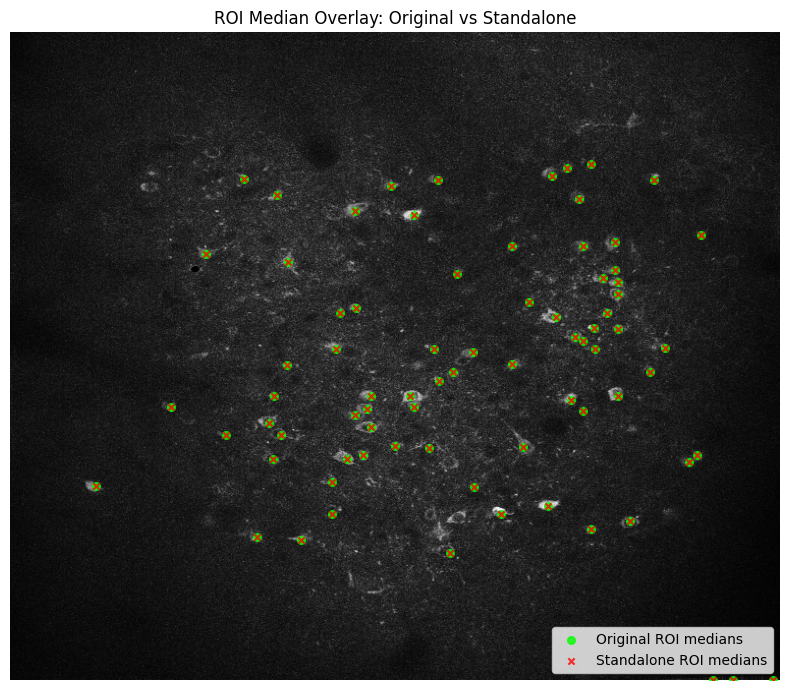

ROI counts: original=77, standalone=77, diff=0
First-N footprint pixel counts:
  ROI 0: expected_npix=215 standalone_npix=215
  ROI 1: expected_npix=239 standalone_npix=239
  ROI 2: expected_npix=189 standalone_npix=189
  ROI 3: expected_npix=198 standalone_npix=198
  ROI 4: expected_npix=145 standalone_npix=145
frame_diff_max=0.0


In [11]:
roi_canvas = expected_new_settings["max_proj"].astype(np.float32)

expected_med = np.array([s["med"] for s in expected_stat], dtype=np.float32)
new_med = np.array([s["med"] for s in new_stat], dtype=np.float32)

roi_count_expected = len(expected_stat)
roi_count_new = len(new_stat)
roi_count_diff = roi_count_expected - roi_count_new

# First-N footprint check (optional diagnostic)
N = min(5, roi_count_expected, roi_count_new)
first_n_pixel_counts = [
    {
        "roi_index": i,
        "expected_npix": int(len(expected_stat[i]["ypix"])),
        "standalone_npix": int(len(new_stat[i]["ypix"])),
    }
    for i in range(N)
]

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(roi_canvas, cmap="gray")
if expected_med.size:
    ax.scatter(expected_med[:, 1], expected_med[:, 0], s=30, c="lime", label="Original ROI medians", alpha=0.8)
if new_med.size:
    ax.scatter(new_med[:, 1], new_med[:, 0], s=20, c="red", marker="x", label="Standalone ROI medians", alpha=0.8)
ax.set_title("ROI Median Overlay: Original vs Standalone")
ax.set_axis_off()
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

print(f"ROI counts: original={roi_count_expected}, standalone={roi_count_new}, diff={roi_count_diff}")
print("First-N footprint pixel counts:")
for row in first_n_pixel_counts:
    print(
        f"  ROI {row['roi_index']}: expected_npix={row['expected_npix']} "
        f"standalone_npix={row['standalone_npix']}"
    )

frame_diff = (
    original_frame_snapshot.astype(np.float32)
    - standalone_frame_snapshot.astype(np.float32)
)
frame_diff_max = float(np.max(np.abs(frame_diff))) if frame_diff.size else 0.0
print(f"frame_diff_max={frame_diff_max}")


In [12]:
float_error_values = [row["max_abs_error"] for row in comparison_rows if row["max_abs_error"] is not None]
global_max_float_error = max(float_error_values) if float_error_values else 0.0

mismatched_sections = [section for section, info in top_level_report.items() if not info["pass"]]

print("Final Summary")
print("=============")
print(f"Architecture guard initialized: {architecture_guard_initialized}")
print(f"Architecture guard active during execution: {architecture_guard_status}")
print(f"Helper import strategy: {import_strategy_used}")
print(f"Package import strategy: {package_import_strategy}")
print(f"Standalone package name: {standalone_package_name}")
print(f"Overall strict comparison PASS: {overall_pass}")
print(f"Mismatched sections: {len(mismatched_sections)}")
if mismatched_sections:
    print(f"Section mismatches: {mismatched_sections}")
print(f"Global max absolute float error: {global_max_float_error}")
print(f"Frame-level max absolute diff: {frame_diff_max}")


Final Summary
Architecture guard initialized: True
Architecture guard active during execution: True
Helper import strategy: repo_root_bootstrap
Package import strategy: standard
Standalone package name: separation.detection
Overall strict comparison PASS: True
Mismatched sections: 0
Global max absolute float error: 0.0
Frame-level max absolute diff: 0.0
